# Use PyVista to Visualize a Tornado Simulation

Thanks for the script, [Bane!](https://twitter.com/banesullivan)!

Requires:

- `pyvista`, `netCDF4`, and `tqdm`
- `vtk 8.2.0`
- install `colorcet` for the `"CET_D1A"` colormap!
- also uses `cmocean` for other colormaps

To install, create an empty conda environment and install the following packages:
```
conda create -n pyvista python=3.7
conda install -c conda-forge vtk=8.2.0 pyvista netCDF4 tqdm colorcet cmocean
```

In [1]:
import pyvista as pv
import numpy as np
import netCDF4 as nc
import vtk, glob
from tqdm import tqdm
from colorcet import *
import gc 

## This is required when using the volume render functionality.
## Not necessary for 3D meshes or surfaces
pv.rcParams["use_panel"] = False

# Environment Report for Reproducibilty

In [2]:
## Just some useful debugging info if you have any issues
pv.Report(["netCDF4", "tqdm"])

--------------------------------------------------------------------------------
  Date: Thu Oct 31 19:06:55 2019 UTC

             Linux : OS
                 8 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
           Jupyter : Environment

  Python 3.7.4 (default, Aug 13 2019, 20:35:49)  [GCC 7.3.0]

             1.4.2 : netCDF4
            4.36.1 : tqdm
            0.22.4 : pyvista
             8.2.0 : vtk
            1.17.2 : numpy
             2.6.1 : imageio
             1.4.3 : appdirs
             0.4.3 : scooby
             3.1.1 : matplotlib
             5.9.2 : PyQt5
             7.8.0 : IPython
             7.5.1 : ipywidgets
             1.0.0 : colorcet
               2.0 : cmocean

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------

# Load the Data

Here I load the data from the netCDF files and create PyVista meshed (VTK datasets)

In [3]:
## Read in the NetCDF with the parcels
pc_ds = nc.Dataset("volume_and_parcels/30m_tkeparcels_small.nc")
print(pc_ds.variables.keys())
print()

## Read in the NetCDF with the volumetric model data
model_ds = nc.Dataset("volume_and_parcels/30m_tke_small.04200.166600.nc" )
print(model_ds.variables.keys())
print()

odict_keys(['xpos', 'ypos', 'zpos', 'u', 'v', 'w', 'uturb', 'vturb', 'wturb', 'udiff', 'vdiff', 'wdiff', 'khh', 'xvort', 'yvort', 'zvort', 'xvorttilt', 'yvorttilt', 'zvorttilt', 'xvortstretch', 'yvortstretch', 'zvortstretch', 'xvortsolenoid', 'yvortsolenoid', 'zvortsolenoid', 'xvortbaro', 'yvortbaro', 'xvortturb', 'yvortturb', 'zvortturb', 'xvortdiff', 'yvortdiff', 'zvortdiff', 'prespert', 'thrhopert'])

odict_keys(['xh', 'yh', 'zh', 'xf', 'yf', 'zf', 'time', 'X0', 'Y0', 'X1', 'Y1', 'Z0', 'Z1', 'thrhopert', 'vortmag', 'winterp', 'u0', 'v0', 'th0', 'pres0', 'pi0', 'qv0'])



## Handle the point cloud

This is `pyvista.PolyData` (`vtkPolyData`).
This is going to read in our position arrays for the parcels, and the array
we want the lagrangian parcels to be colored by. In this case, the coloring
is from `zvortstretch` and the position arrays are `xpos`, `ypos`, and `zpos`.

In [4]:
## Spatial reference of the Lagrangian point cloud
poskeys = ["xpos", "ypos", "zpos"]
xt = pc_ds[poskeys[0]]
yt = pc_ds[poskeys[1]]
zt = pc_ds[poskeys[2]]

## Array to color the Lagrangian point cloud by
pc_array = "zvortstretch"
var = pc_ds.variables[pc_array]
## Get the min/max of the color array
clim = [np.min(var), np.max(var)]

npar, nt = xt.shape
npar, nt

(3000, 901)

## Time-varying Lagrangian particle trajectories

This handles taking the Lagrangian particle trajectory position arrays and making them into a data structure that PyVista can readily render as a point cloud. Additionally, we define a function that tells PyVista how the data updates in time. 

In [5]:
## This function defines how our point cloud caries in time
def update_pc(t):
    """Update the Lagrangian particle trajectory point cloud to a new time step."""
    # updates the point cloud inplace
    pc.points[:] = np.c_[xt[:,t], yt[:,t], zt[:,t]]
    pc[pc_array][:] = var[:,t]
    return

## Inititalize the point cloud
pc = pv.PolyData(np.c_[xt[:,0], yt[:,0], zt[:,0]])
pc[pc_array] = var[:,0]


In [6]:
## Creates streamlines from the point cloud
nodes = np.dstack((xt, yt, zt))
streams = pv.MultiBlock()
for index in tqdm(range(0, npar)):
    tracer = pv.lines_from_points(nodes[index,:,:])
    streams.append(tracer)
    
streams = streams.combine()
streams[pc_array] = pc_ds[pc_array][:].ravel()

100%|██████████| 3000/3000 [00:01<00:00, 2767.08it/s]


## Handle the model grid
|
The netCDF file has a meshgrid saved (`pyvista.StructuredGrid`/`vtkStructuredGrid`) but it is way more efficeint to use image data (`pyvista.UniformGrid`/`vtkImageData`). Below, I have it set to create image data, but we can easily get away with this because our data is on a rectillinear mesh with isotropic grid spacing. Also this is mainly just to show you that there are several ways to make a mesh from these data.


# WARNING: IF YOU ARE NOT USING A REGULAR MESH WITH ISOTROPIC SPACING, BE CAREFUL AND USE THE SLOWER MESH OR INTERPOLATE TO A REGULAR GRID.

It's also worth noting that this grid is using the scalar mesh, and none of the staggered vector meshes (ie zf, yf, xf). If you are plotting a vector field, either a) interpolate to the scalar mesh or b) create multiple grids, which should be allowed.

In [7]:
## Get bounds of the entire simulation
bounds = [np.min(xt), np.max(xt),
          np.min(yt), np.max(yt),
          np.min(zt), np.max(zt)]
print(bounds)


## Fetch data for the static model
## - typically better to use image data if you can
## - pyvista.UniformGrid wraps vtk.vtkImageData
if False:
    ## Create a structured grid - safer
    x = model_ds["xh"][:] * 1000
    y = model_ds["yh"][:] * 1000
    z = model_ds["zh"][:] * 1000
    xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
    grid = pv.StructuredGrid(xx, yy, zz)
else:
    ## Create image data - better optimized for viz
    
    ## grid units are in km, convert to m
    ## to work with trajectories
    x = model_ds["xh"][:] * 1000
    y = model_ds["yh"][:] * 1000
    z = model_ds["zh"][:] * 1000
    
    ## Get the grid spacing
    xs = np.around(np.unique(np.diff(x)).mean(), decimals=3)
    ys = np.around(np.unique(np.diff(y)).mean(), decimals=3)
    zs = np.around(np.unique(np.diff(z)).mean(), decimals=3)
    ## If you have only 1 vertical level this freaks out... this
    ## avoids said freakout. 
    if (np.isnan(zs)): zs = xs
    grid = pv.UniformGrid()
    grid.spacing = xs, ys, zs
    grid.origin = np.min(x), np.min(y), np.min(z)
    grid.dimensions = len(x), len(y), len(z)

[-7103.1533, -100.0, -3285.0127, 900.0, 30.0, 4032.569]


In [8]:
## Arrays used for plotting
grid["winterp"] = model_ds["winterp"][:].ravel()
grid["thrhopert"] = model_ds["thrhopert"][:].ravel()
grid["vortmag"] = model_ds["vortmag"][:].ravel()

# Filter Datasets

Apply a contour and a slice to the model

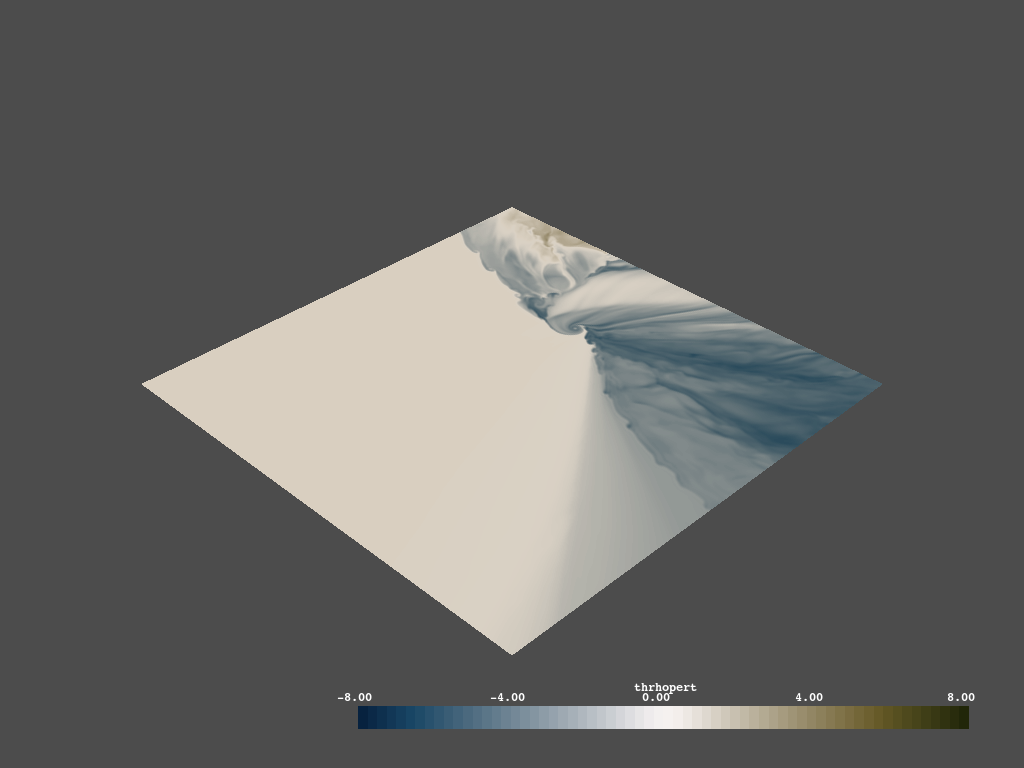

In [9]:
## Define how the volumetric fields update in time. 
def update_sf(t):
    model_ds = nc.Dataset(files[t])
    grid["thrhopert"] = model_ds["thrhopert"][:].ravel()
    grid["winterp"] = model_ds["winterp"][:].ravel()
    grid["vortmag"] = model_ds["vortmag"][:].ravel()


## Slice the model at the ground surface
og = grid.center
og[-1] = 30 ## first scalar grid point is at 30 meters

## Plot a horizontal slice of the surface buoyancy perturbation field.
surface = grid.slice("z", origin=og)
surface.plot(scalars="thrhopert", cmap="diff", clim=[-8,8], orig=og)

## Contour the updraft speeds
##  - this might take a sec
isosurf = grid.contour([30, 40, 50], scalars="winterp") ## 3 specific contour levels in m/s

# Plotting!

This is the fun part!

## Static Scene 1

Lots of contours all with opacity to mimic volume rendering

In [10]:
## Note the custom opacity ramp
## - this is used for the streamlines to mask parts of the
## line we don't care about
ramp = [0.0,0.0,0.0, 0.0, 0.07, 0.5, 0.75, 1.]

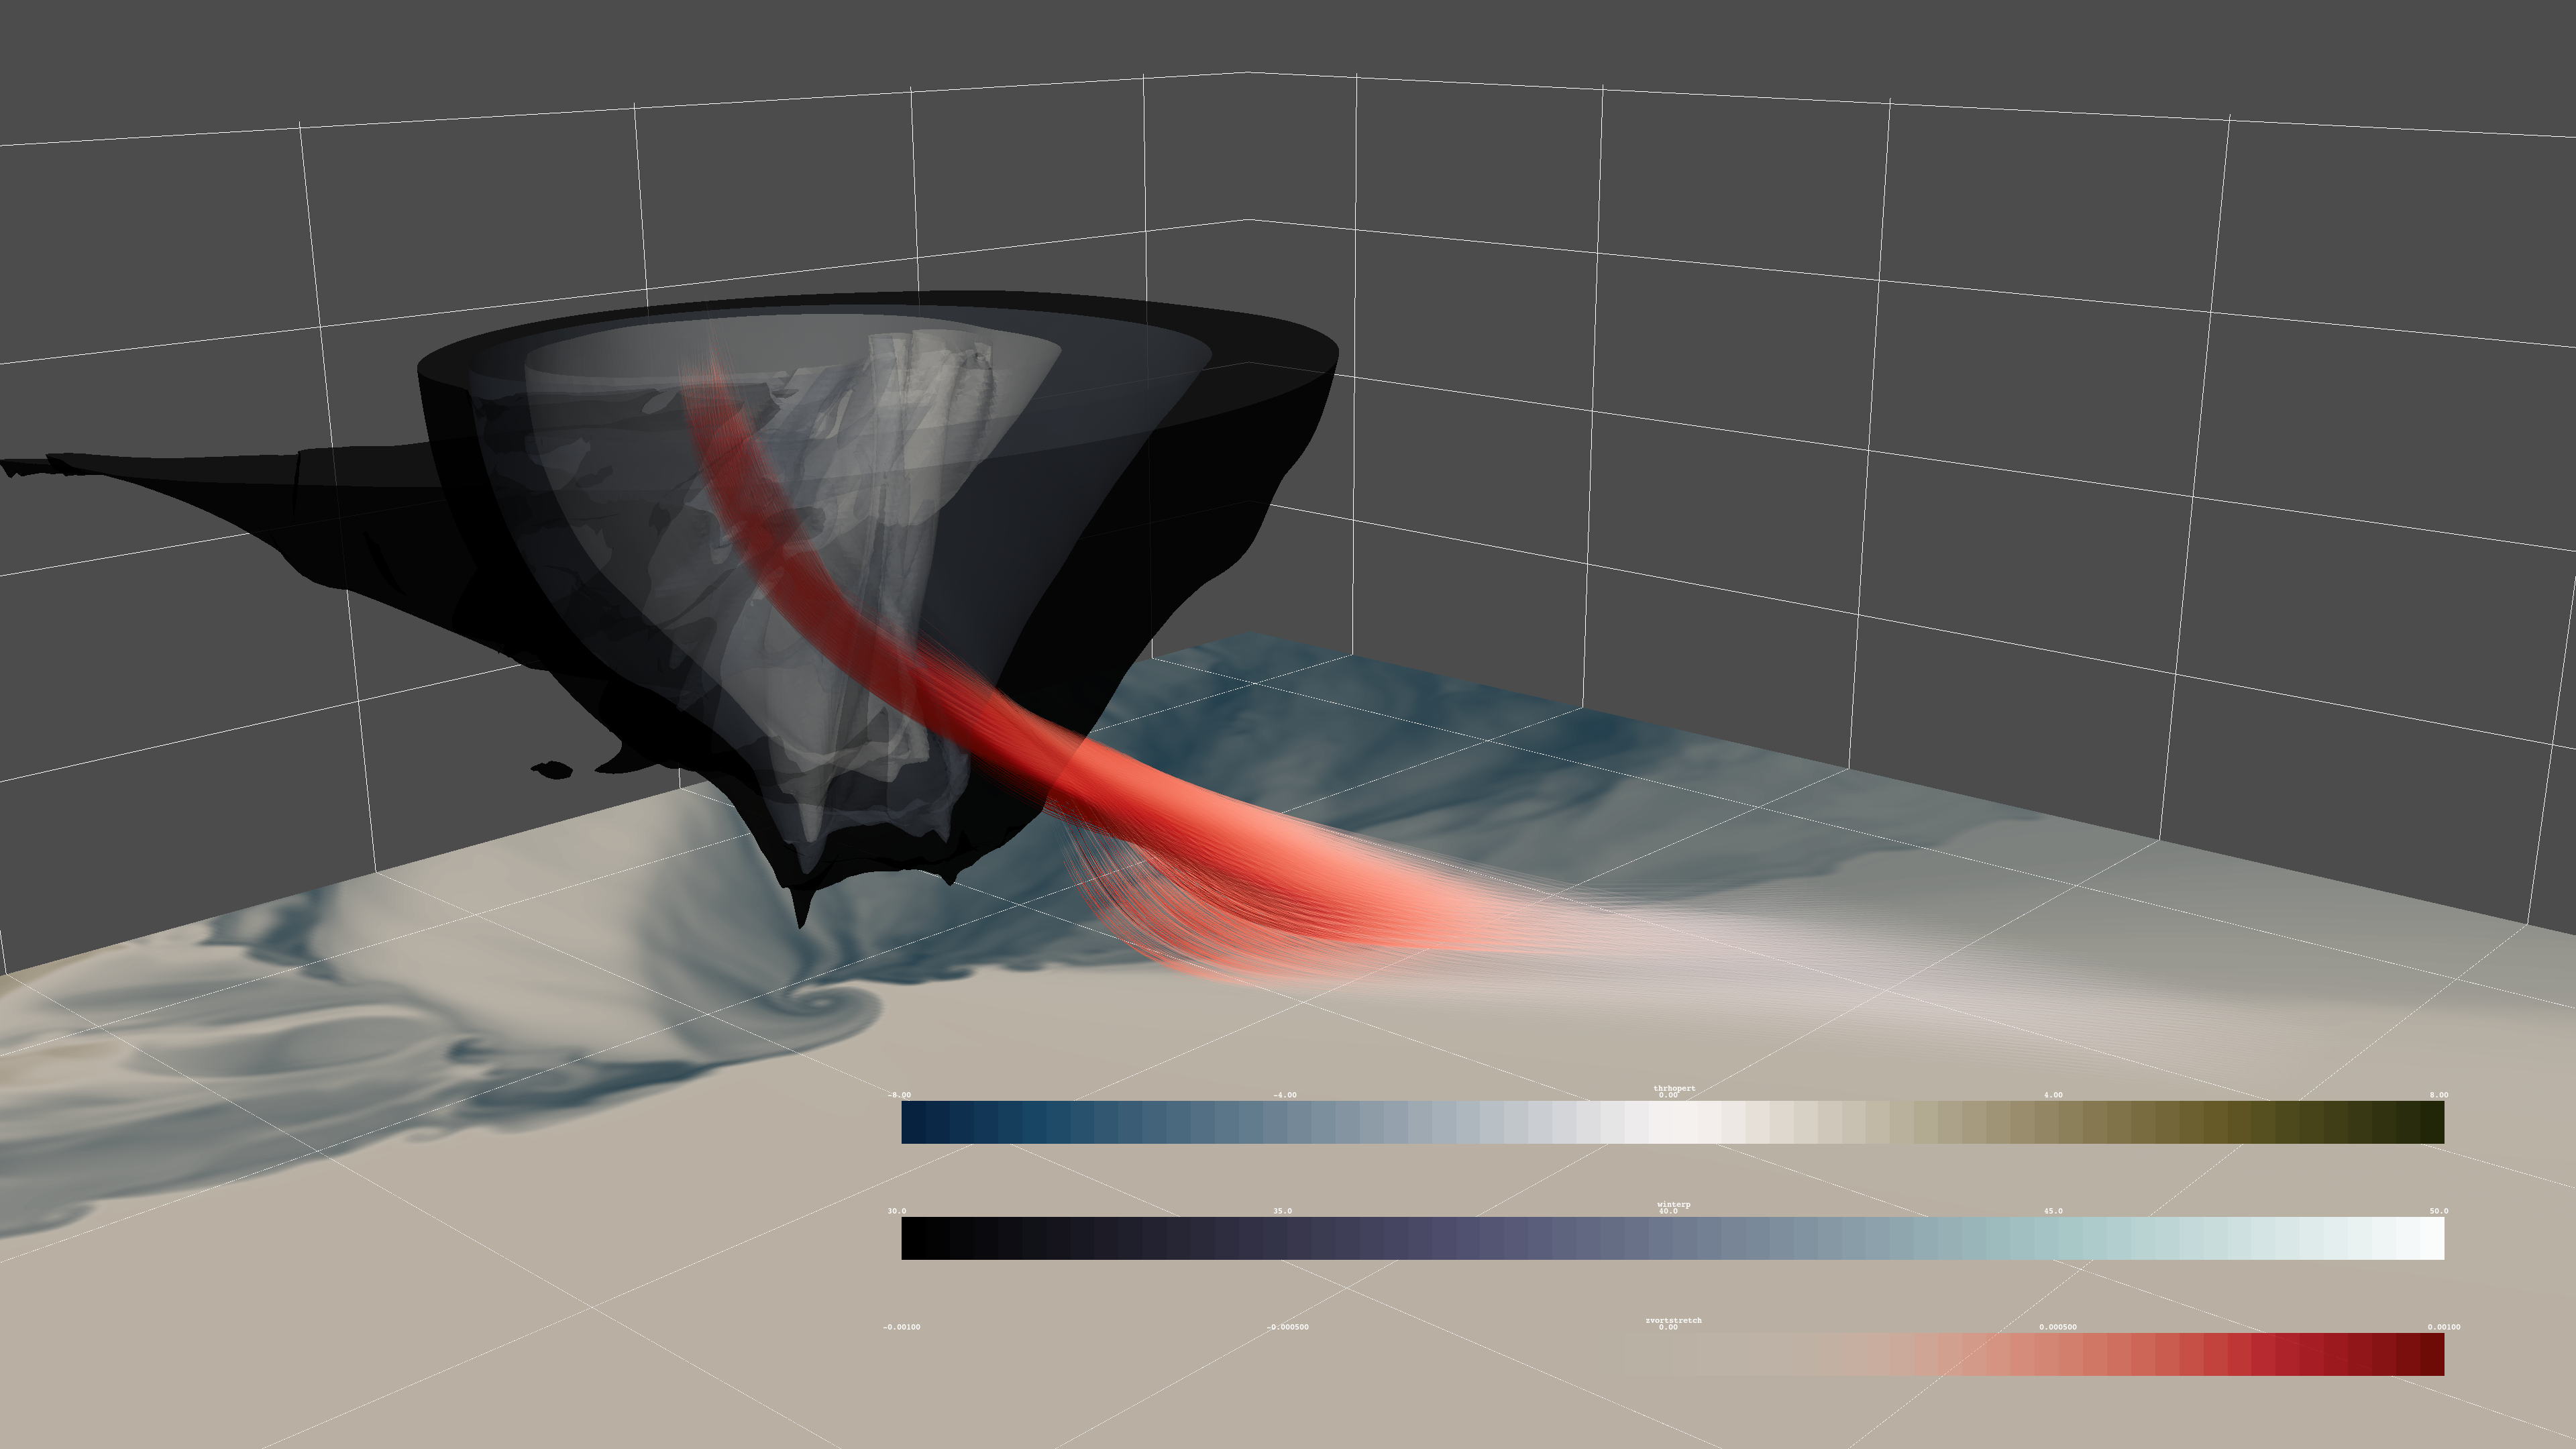

69

In [24]:
## Create the render engine. Here we can set the window size, multisampling,
## and whether or not we're in a notebook. Setting notebook=True will display
## the resulting image in the notebook and it will not be interactive. 
## Setting notebook=False will not display the image in the notebook, but
## will open an interactive display.
p = pv.Plotter(notebook=True,
               window_size=[1920*2, 1080*2], 
               multi_samples=16)


## Add our Lagrangian parcel streamlines to the render engine. 
## We specify the color range of zvortstretch with clim, and
## use teh custom ramp as the opacity argument. This will make
## streamlines with no vrtoex stretching transparent. 
p.add_mesh(streams, clim=[-1e-3, 1e-3], 
            opacity=ramp,
            cmap="CET_D1A")

## Add the 3 updraft isosurfaces to the scene. 
p.add_mesh(isosurf, scalar="winterp", cmap="bone", opacity=0.75, clim=[30,50])

## Add the buoyancy field underneath everything. 
p.add_mesh(surface, scalars="thrhopert", cmap="diff", clim=[-8,8])

## Set the camera position and orientation.
p.camera_position = [(4000., -11000., 5000.),
                     (-5000, -1000., 1000.),
                     (0, 0, 1)]
p.show_grid()

## Save a screenshot!
p.screenshot("example1.png")
p.show()


pv.close_all()
gc.collect()


## Scene 2

This one opens in an interactive window!

In [26]:
p = pv.Plotter(notebook=False,
               window_size=[1920, 1080], 
               multi_samples=16)


# Add three isosurfaces from the model
grid.set_active_scalar("vortmag")
p.add_volume(grid, scalars="vortmag", clim=[-6, 10], cmap="diff", opacity="sigmoid_6", mapper="gpu")

# Add the ground surface data
p.add_mesh(surface, scalars="thrhopert", cmap="diff", clim=[-8,8], mapper="gpu")


# Note the custom opacity ramp
p.add_mesh(streams, clim=[-1e-3, 1e-3], opacity=ramp, cmap="CET_D1A", mapper="gpu")

p.camera_position = [(4000., -11000., 5000.),
                     (-5000, -1000., 1000.),
                     (0, 0, 1)]
p.show_grid()
p.show()
p.screenshot("example2.png")
pv.close_all()

True

## Dynamic Scene

This is some example code to show how animations would work, animating only the parcels

In [ ]:
# initialize the point cloud
update_pc(0)

## Create our render engine
p = pv.Plotter(notebook=False, off_screen=True, 
               window_size=[1920*2, 1080*2], multi_samples=16)

## Open up an MP4 with a 60 FPS framerate
p.open_movie("parcel_movie.mp4", framerate=60)


## Add bounds to make sure the camera doesnt get wacky
p.add_mesh(pv.Box(bounds), opacity=0, style="wireframe")

## Add the point cloud in the scene
p.add_mesh(pc, clim=[-1e-3, 1e-3], 
           opacity=1.0,
           cmap="CET_D1A")

## Att the surface buoyancy
p.add_mesh(grid, scalars="thrhopert", cmap="diff", clim=[-8,8])

## Camera position
p.camera_position = [(4000., -11000., 5000.),
                     (-5000, -1000., 1000.),
                     (0, 0, 1)]

p.show(auto_close=False)

## Run through each frame - since all of the parcels
## are already read into memory at the start, this is
## really fast. If you're opening a new file each time
## step, it'll definitely slow down but isn't miserable
p.write_frame()  ## write initial data
for tstep in tqdm(np.arange(0, nt-1)):
    update_pc(tstep)
    ## Commented out the updating of the
    ## surface slice because the data I 
    ## provided with the notebook only has
    ## 1 time step in it
    #update_sf(tstep)
    p.write_frame()
pv.close_all()

100%|█████████▉| 899/900 [00:43<00:00, 20.76it/s]